# Mastering PyTorch By Ashish Ranjan Jha

## Running a pretrained VGG model

The name VGG is derived from **Visual Geometry Group of Oxford University**, where this model was invented. Compared to the 8 layers and 60 million parameters of AlexNet, VGG consist of 13 layers (10 convulational layer and 3 fully connected layers) and 138 million parameters. VGG basically stacks more layers onto the AlexNet architecture with smaller convulation kernels (2x2 or 3x3).

Hence, VGG's novelty lies in the unprecendented level of depth that it brings with its architecture.

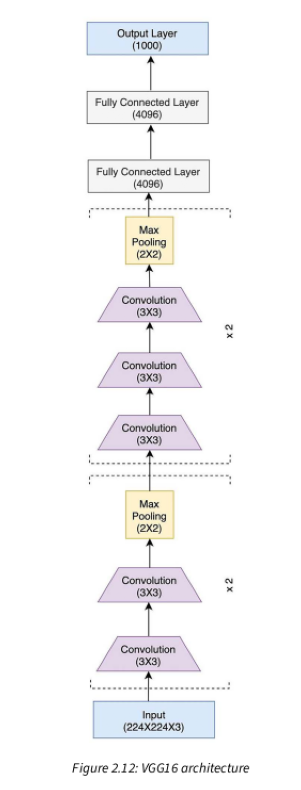

In [1]:
import matplotlib.pyplot as plt 

img = plt.imread('/kaggle/input/vgg16-architecture/VGG16 Architecture')

plt.figure(figsize = (30,10))
plt.imshow(img)
plt.axis('off')
plt.show()

The preceding VGG architecture is called **VGG13**, because of the 13 layers. Other variants are VGG16 and VGG19, consisting of 16 and 19 layers, respectively. There is another set of variants – **VGG13_bn, VGG16_bn,** and **VGG19_bn**, where **bn** suggests that these models also consist of batch-normalization layers.

In [2]:
# Import dependencies 
import os 
import json
import torch 
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models 
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt 
import numpy as np 
import ast 

In [3]:
# Define the dataset paths
data_dir = '/kaggle/input/hymenoptera-data/hymenoptera_data'

# Define the transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
    ]),
}

# Create the dataset objects
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

# Create the dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

# Get dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
# Download the ImageNet labels
!wget -O imagenet1000_clsidx_to_labels.txt https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

# Load the labels and create a mapping
with open('imagenet1000_clsidx_to_labels.txt') as f:
    classes_data = json.load(f)  
    
# Print the first 5 mappings
print({k: classes_data[k] for k in range(5)})


--2024-08-21 09:22:04--  https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14209 (14K) [text/plain]
Saving to: 'imagenet1000_clsidx_to_labels.txt'

imagenet1000_clsidx 100%[===================>]  13.88K  --.-KB/s    in 0s      

2024-08-21 09:22:04 (52.6 MB/s) - 'imagenet1000_clsidx_to_labels.txt' saved [14209/14209]

{0: 'tench', 1: 'goldfish', 2: 'great white shark', 3: 'tiger shark', 4: 'hammerhead shark'}


In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.490, 0.449, 0.411])
    std = np.array([0.231, 0.221, 0.230])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def visualize_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    cols = 3  
    rows = (num_images + cols - 1) // cols  
    fig = plt.figure(figsize=(cols * 4, rows * 4))  

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Debugging outputs
            print(f"Predicted indices: {preds.cpu().numpy()}")  
            print(f"Class names length: {len(class_names)}") 

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(rows, cols, images_so_far)
                ax.axis('off')
                
                # Debugging individual prediction
                print(f"Prediction index: {preds[j].item()}")
                
                # Check if the predicted index is valid
                if preds[j] < len(class_names):
                    ax.set_title(f'Predicted: {class_names[preds[j]]}')
                else:
                    ax.set_title(f'Predicted: Out of Range')

                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()  # Adjust layout to prevent overlapping
                    plt.show()
                    return
                
        model.train(mode=was_training)
        plt.tight_layout()  # Adjust layout to prevent overlapping
        plt.show()

In [6]:
def calculate_accuracy(model, dataloader, device):
    model.eval()  
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():  
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Update counts
            correct_predictions += torch.sum(preds == labels).item()
            total_samples += labels.size(0)
    
    accuracy = (correct_predictions / total_samples) * 100
    return accuracy

In [7]:
# Load and modify VGG13 model
def load_and_modify_vgg13():
    model = models.vgg13(pretrained=True)
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, len(class_names))
    model = model.to(device)
    return model

# Freeze layers
def freeze_layers_vgg13(model, freeze_until_layer='classifier'):
    for name, param in model.named_parameters():
        if freeze_until_layer in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

# Training loop
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / dataset_sizes['train']
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')
    print('Training complete')

In [8]:
# Load model
model = load_and_modify_vgg13()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Freeze layers
freeze_layers_vgg13(model, freeze_until_layer='classifier')

# Train the model
train_model(model, dataloaders, criterion, optimizer, num_epochs=25)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:28<00:00, 19.0MB/s] 


Epoch 0/24, Loss: 0.5476
Epoch 1/24, Loss: 0.4085
Epoch 2/24, Loss: 0.3584
Epoch 3/24, Loss: 0.3709
Epoch 4/24, Loss: 0.2531
Epoch 5/24, Loss: 0.3277
Epoch 6/24, Loss: 0.3133
Epoch 7/24, Loss: 0.3386
Epoch 8/24, Loss: 0.2773
Epoch 9/24, Loss: 0.2721
Epoch 10/24, Loss: 0.2344
Epoch 11/24, Loss: 0.2281
Epoch 12/24, Loss: 0.1944
Epoch 13/24, Loss: 0.1847
Epoch 14/24, Loss: 0.2361
Epoch 15/24, Loss: 0.2169
Epoch 16/24, Loss: 0.2275
Epoch 17/24, Loss: 0.1342
Epoch 18/24, Loss: 0.2220
Epoch 19/24, Loss: 0.1483
Epoch 20/24, Loss: 0.1907
Epoch 21/24, Loss: 0.1998
Epoch 22/24, Loss: 0.1684
Epoch 23/24, Loss: 0.1412
Epoch 24/24, Loss: 0.1526
Training complete


In [9]:
# Calculate accuracy on validation set
val_accuracy = calculate_accuracy(model, dataloaders['val'], device)
print(f'Validation Accuracy: {val_accuracy:.2f}%')

Validation Accuracy: 93.46%


Predicted indices: [0 1 1 0]
Class names length: 2
Prediction index: 0
Prediction index: 1
Prediction index: 1
Prediction index: 0
Predicted indices: [1 0 1 1]
Class names length: 2
Prediction index: 1
Prediction index: 0


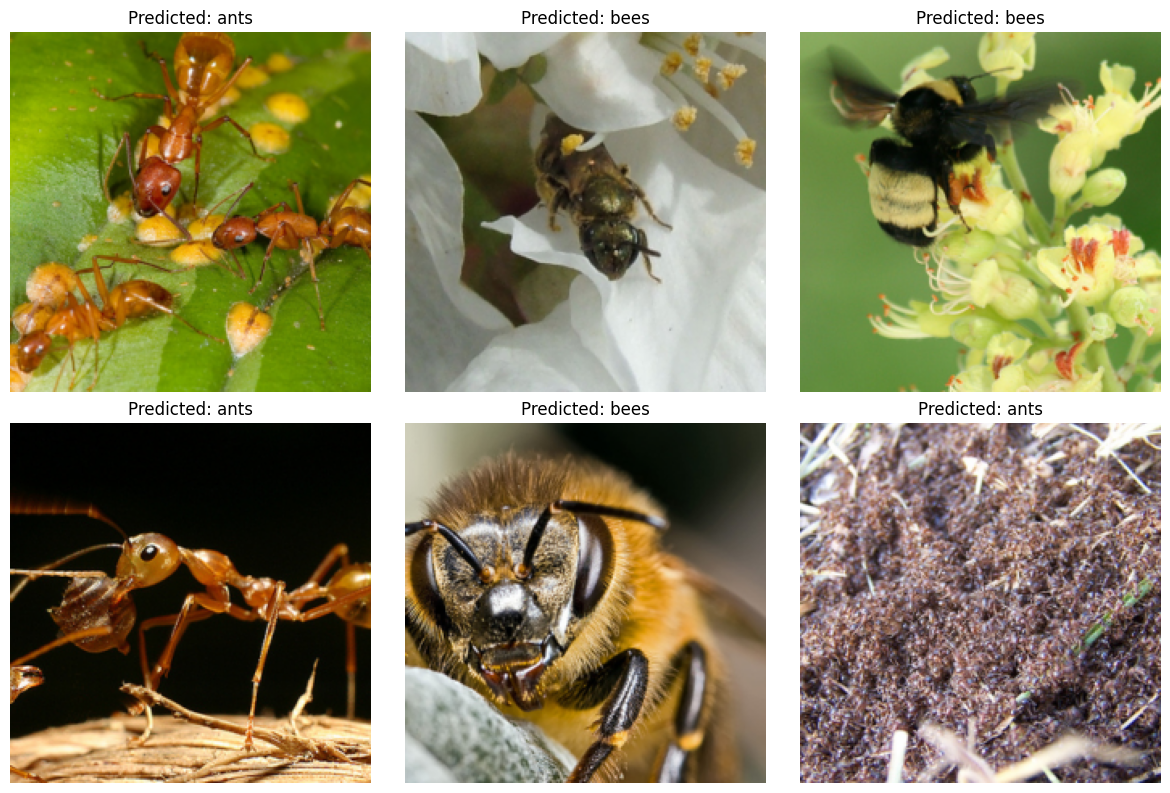

In [10]:
# Visualize predictions
visualize_predictions(model)

In this exercise, we utilized the pre-trained VGG13 model to classify images from the Hymenoptera dataset, containing ants and bees. By modifying the final layer of VGG13 to match our two-class problem and freezing the earlier layers, we retained valuable features learned from the ImageNet dataset. The model demonstrated its ability to effectively generalize by achieving a reasonable accuracy on the validation set, showing that even models trained on different datasets can still extract and apply relevant visual features to new tasks. This exercise highlights the power of transfer learning and PyTorch’s out-of-the-box capabilities in adapting pre-trained models to specific classification problems.

## Exploring GoogLeNet and Inception v3

GoogLeNet emerged as a radically different type of CNN architecture
that is composed of a module of parallel convolutional layers called the inception module. Because of this, GoogLeNet is also called Inception v1 (v1 marked the first version as more versions came along later). Some of the drastically new elements introduced by GoogLeNet were the following:
- The inception module – a module of several parallel convolutional layers
- Using 1x1 convolutions to reduce the number of model parameters
- Global average pooling instead of a fully connected layer – reduces overfitting
- Using auxiliary classifiers for training – for regularization and gradient stability GoogLeNet has 22 layers, which is more than the number of layers of any VGG model variant. Yet, due to some of the optimization tricks used, the number of parameters in GoogLeNet is 5 million, which is far less than the 138 million parameters of VGG. Let’s expand on some of the key features of this model.

### Inception Modules

One of the most significant contributions of this model is the introduction of a convolutional module that employs multiple convolutional layers running in parallel. These layers are eventually concatenated to form a single output vector. The parallel convolutional layers utilize different kernel sizes, such as 1x1, 3x3, and 5x5, allowing the model to capture visual information at various levels of detail from the image. In addition to these convolutions, a 3x3 max pooling layer further enhances feature extraction.

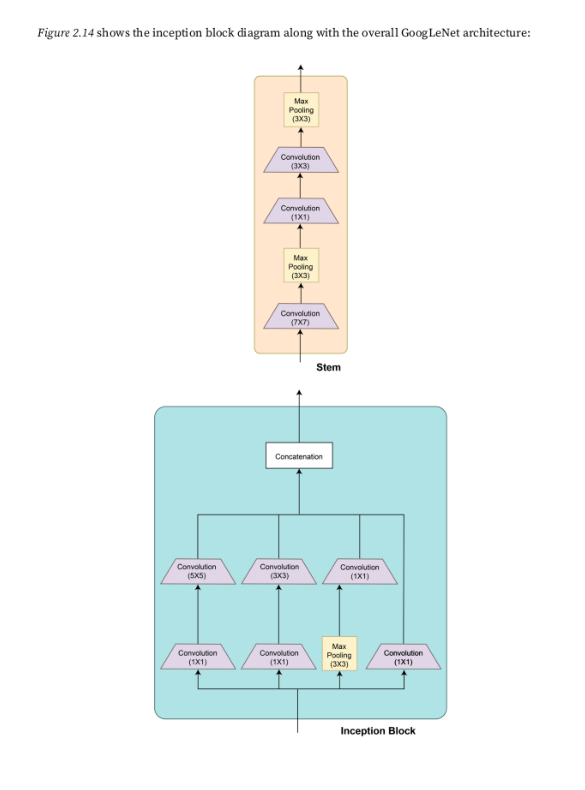

In [11]:
import matplotlib.pyplot as plt

img = plt.imread('/kaggle/input/inception-block-diagram/Inception Block Diagram.png')

plt.figure(figsize=(30,10))
plt.imshow(img)
plt.axis('off')
plt.show()

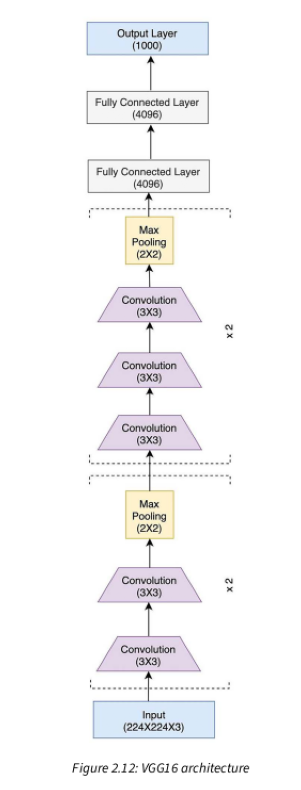

In [12]:
arch = plt.imread('/kaggle/input/vgg16-architecture/VGG16 Architecture')

plt.figure(figsize=(30,10))
plt.imshow(arch)
plt.axis('off')
plt.show()

Let's build the inception module by using this architecture diagram.

In [13]:
# Import dependencies
import torch 
import torch.nn as nn

In [14]:
class InceptionModule(nn.Module):
    def __init__(self, input_planes, n_channels1x1, 
                 n_channels3x3red, n_channels3x3, n_channels5x5red,
                 n_channels5x5, pooling_planes):
        """
        :param input_planes: Number of input channels (depth) of the feature map.
        :param n_channels1x1: Number of output channels for the 1x1 convolution branch.
        :param n_channels3x3red: Number of output channels for the 1x1 convolution in the 3x3 branch (used for depth reduction).
        :param n_channels3x3: Number of output channels for the 3x3 convolution branch.
        :param n_channels5x5red: Number of output channels for the 1x1 convolution in the 5x5 branch (used for depth reduction).
        :param n_channels5x5: Number of output channels for the 5x5 convolution branch (achieved through two 3x3 convolutions).
        :param pooling_planes: Number of output channels for the 1x1 convolution after the 3x3 max pooling branch.
        """
        
        # 1x1 convolution branch
        self.block1 = nn.Sequential(
            nn.Conv2d(input_planes, n_channels1x1, kernel_size=1),# 1x1 convolution layer
            nn.BatchNorm2d(n_channels1x1),  
            nn.ReLU(True),  
        )
        
        # 1x1 convolution -> 3x3 convolution branch
        self.block2 = nn.Sequential(
            nn.Conv2d(input_planes, n_channels3x3red, kernel_size=1), # 1x1 convolution to reduce depth
            nn.BatchNorm2d(n_channels3x3red),  
            nn.ReLU(True), 
            nn.Conv2d(n_channels3x3red, n_channels3x3, kernel_size=3, padding=1), # 3x3 convolution
            nn.BatchNorm2d(n_channels3x3),  
            nn.ReLU(True),  
        )
        
        # 1x1 convolution -> 5x5 convolution branch
        self.block3 = nn.Sequential(
            nn.Conv2d(input_planes, n_channels5x5red, kernel_size=1),  # 1x1 convolution to reduce depth
            nn.BatchNorm2d(n_channels5x5red), 
            nn.ReLU(True),  
            nn.Conv2d(n_channels5x5red, n_channels5x5, kernel_size=3, padding=1),  # First 3x3 convolution (part of 5x5)
            nn.BatchNorm2d(n_channels5x5),  
            nn.ReLU(True),  
            nn.Conv2d(n_channels5x5, n_channels5x5, kernel_size=3, padding=1), # Second 3x3 convolution (part of 5x5)
            nn.BatchNorm2d(n_channels5x5),  
            nn.ReLU(True),   
        )
        
        # 3x3 max pooling -> 1x1 convolution branch
        self.block4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),  # 3x3 max pooling layer
            nn.Conv2d(input_planes, pooling_planes, kernel_size=1),  # 1x1 convolution after pooling
            nn.BatchNorm2d(pooling_planes),   
            nn.ReLU(True),   
        )

    def forward(self, ip):
        op1 = self.block1(ip)  # Forward pass through block1
        op2 = self.block2(ip)  # Forward pass through block2
        op3 = self.block3(ip)  # Forward pass through block3
        op4 = self.block4(ip)  # Forward pass through block4
        return torch.cat([op1, op2, op3, op4], 1)  # Concatenate outputs from all blocks along the channel dimension

### 1x1 convulations

In addition to the parallel convolutional layers in an inception module, each parallel layer has a preceding 1x1 convolutional layer. 1x1 convolutions primarily function as a tool for dimensionality reduction. While they do not alter the spatial dimensions (width and height) of the input image, they significantly impact the depth of the feature maps. This is particularly important in deep learning, where managing the number of channels (or depth) can lead to more efficient computations.
By applying a 1x1 convolution before the parallel layers of 3x3 and 5x5 convolutions, the model can effectively reduce the number of input channels. Reducing the number of parameters not only helps build a lighter model but also combats overfitting. 

Moreover, by reducing the input depth, the subsequent convolutional layers can focus on learning more relevant features without being overwhelmed by unnecessary information.

### Global average pooling

The GoogLeNet architecture incorporates a 7x7 average pooling layer just before the penultimate output layer. The 7x7 average pooling layer in GoogLeNet serves a critical function by significantly reducing the model's parameter count and enhancing its robustness against overfitting. Without this layer, the model would have millions of additional parameters due to the dense connections of a fully connected layer.